# Projektpräsentation: Vorhersagen von Maiskrankheiten mittles Bildanalyse
Dario Cantore

## Einführung und Motivation
* Fortschritt und wachsende Bevölkerungen basieren auf ausreichender Versorgung durch Grundnahrungsmittel
* In der Vergangenheit hat dies zu zielgerichteter Züchtung  spezifischer, effizienterer Sorten verschiedener Grundnahrungsmittel die sich immer stärker ausgebreitet haben
* Dies führt allerdings zu immer größer werdendem Risiko sollten ehemals effiziente Sorten bedroht werden - wie bei Bananen bereits der Fall (https://time.com/5730790/banana-panama-disease/)
* Um Ausbreitung zu vermeiden müssen Krankheiten in bestehenden Populationen effizient entdeckt werden um Behandlung so schnell wie möglich zu ermöglichen

**Die folgende Projektarbeit wird sich auf Mais fokussieren, ein weiteres Nahrungsmittel das sich mehr und mehr auf eine Sorte fokussiert ("Dent" / "Field corn"), welches bereits von Krankheiten befallen wird die sich durch Wind alleine verbreiten - eine effektive Identifizierung ist essenziell um Verbreitung auf weitere Felder zu vermeiden**

Es werden Deep Learning Algorithmen verwendet um Bilder von gesundem und infizierten Mais zu klassifizieren und Landwirten (mittels Kameras an Traktoren) eine frühe und effiziente Identifizierung zu ermöglichen.

## Struktur
* **Explorative Datenanalyse**
* Modell initialisierung und tuning
* **Modellergebnisse**

**Fett geschriebene Punkte sind Fokus der Präsentation**

## Explorative Datenanalyse
* Der Datensatz wird von Kaggle zu verfügung gestellt (ttps://www.kaggle.com/datasets/sinadunk23/behzad-safari-jalal/)
* Er enthält in verschiedenen Ordnern Bilder von gesundem, "yellow rust" infiziertem, sowie "brown rust" infiziertem Mais

### In einem ersten Schritt werden wir die Daten Laden, Beispielbilder anzeigen, und die Datenfrequenz analysieren

In [169]:
### Import der benötigten libraries / funktionen
import time
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
#from tensorflow.keras.layers import Dense, Dropout, Flatten
#from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU
#import seaborn as sns 
import matplotlib.pyplot as plt
#%matplotlib inline
#import cv2
#import glob as gb
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [152]:
### Setup der Konstanten und Directories
IMG_SIZE = (256, 256) # resolution
CHANNELS = 3 #RGB
train_directory = "./data/train"
val_directory = "./data/val"
BATCH_SIZE = 32

In [153]:
### Laden der Trainings-, Tests, und Validierungsdatensets - Tensorflow / Keras hat eine dedizierte Funktion
train_dataset = image_dataset_from_directory(train_directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='rgb',
                                             subset="training",
                                             seed=42,
                                            validation_split=0.2)
test_dataset = image_dataset_from_directory(train_directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='rgb',
                                            subset="validation",
                                             seed=42,
                                            validation_split=0.2)
validation_dataset = image_dataset_from_directory(val_directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='rgb',
                                             seed=42)
# Definition der Klassennamen
class_names = train_dataset.class_names
print("Klassennamen: ", class_names)

Found 2942 files belonging to 3 classes.
Using 2354 files for training.
Found 2942 files belonging to 3 classes.
Using 588 files for validation.
Found 737 files belonging to 3 classes.
Klassennamen:  ['Brown_rust', 'Healthy', 'Yellow_rust']


Wir sehen dass "Brown rust" sowie "yellow rust" charakteristische Merkmale aufweist die auch bei geringer Bildqualität zumindes vom menschlichen Auge erkannt werden. Untenstehend sehen wir 4 Beispielbilder pro Klasse

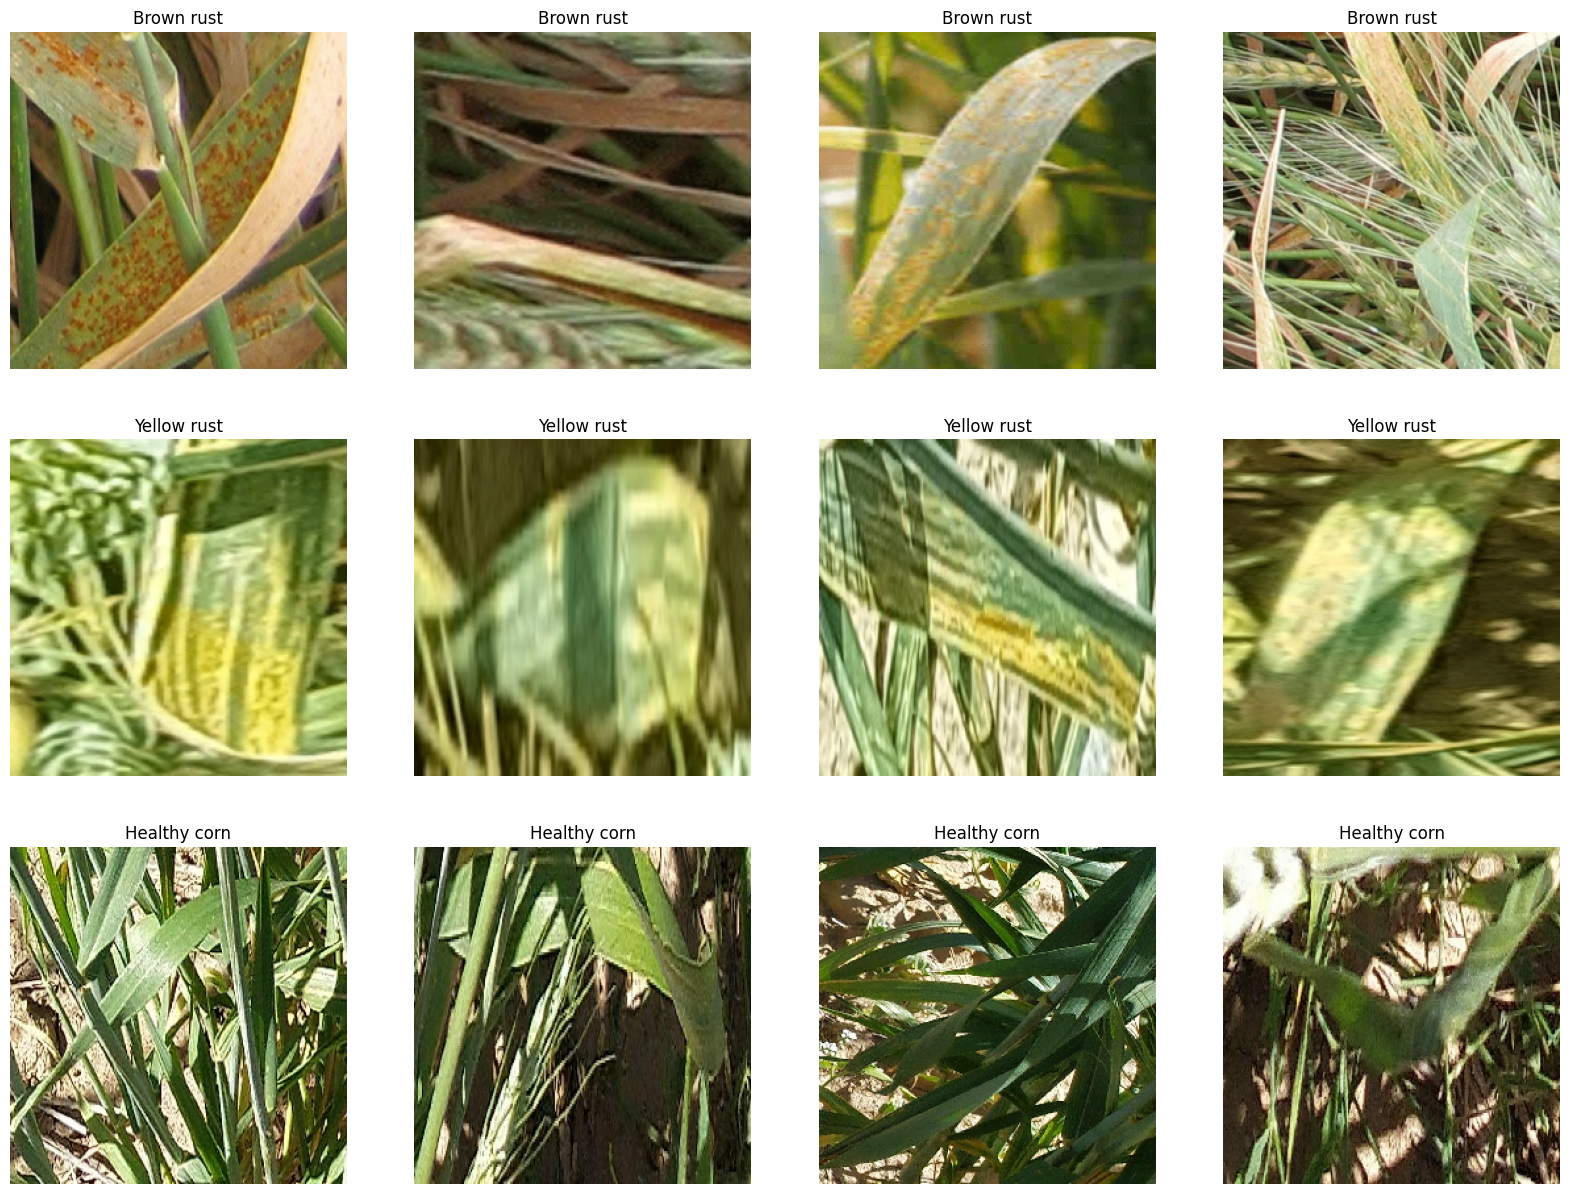

In [154]:
### Beispielplots der Klassen aus dem ersten Batch

#Anzahl plots pro Klasse
IMAGES_PER_CLASS = 4
NUM_DISPLAYED = 3*IMAGES_PER_CLASS
brown_rust = []
yellow_rust = []
healthy = []

#Für images im ersten "Batch" (die ersten BATCHSIZE items) füge die Bilder der passenden Liste hinzu
plt.figure(figsize=(20,15))
for images , labels in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        if class_names[labels[i]] == "Brown_rust":
            brown_rust.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Yellow_rust":   
            yellow_rust.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Healthy":   
            healthy.append(images[i].numpy().astype("uint8"))  
#Für die ersten "NUM_DISPLAYED" Bilder plotte diese
for i in range(0,NUM_DISPLAYED):            
    plt.subplot(3,int(NUM_DISPLAYED/3),i+1)
    if i< IMAGES_PER_CLASS:
        plt.imshow(brown_rust[i])
        plt.title("Brown rust")
    elif i < 2*IMAGES_PER_CLASS:
        plt.imshow(yellow_rust[i-IMAGES_PER_CLASS])
        plt.title("Yellow rust")
    else:
        plt.imshow(healthy[i - 2*IMAGES_PER_CLASS])
        plt.title("Healthy corn")
    plt.axis("off")
    #plt.savefig("./output/explo_img_"+str(i)+".png")

In [155]:
### Definition to calculate counts
def get_counts(dataset):
    dataset_unbatched = tuple(dataset.unbatch())
    labels = []
    for (image,label) in dataset_unbatched:
        labels.append(label.numpy())
    labels = pd.Series(labels)
    count = labels.value_counts()
    return(count)

train_counts = get_counts(train_dataset)
test_counts = get_counts(test_dataset)
validation_counts = get_counts(validation_dataset)


Wir sehen dass sowohl im Testdatensatz als auch im Trainings- und Validierungsdatensatz die Klassen relative ausgewogen sind. Man könnte argumentieren, dass gesunder Mais oversampled werdens sollte. Da das relative gewicht falscher negatives (krank, aber nicht erfasst) jedoch höher ist als falscher positives wurde in diesem Kontext kein oversampling durchgeführt

<Axes: ylabel='Count'>

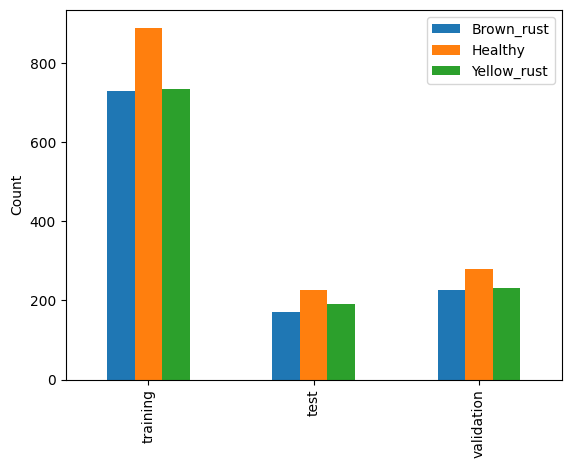

In [159]:
# Calculate counts in a dataframe and format columns as well as rows and visualize them
count_df = pd.DataFrame(data=[train_counts, test_counts, validation_counts], index = ["training","test","validation"])
count_df.rename(columns = dict(zip(range(3),class_names)), inplace=True)
count_df.sort_index(axis = 1, inplace=True)
count_df.plot(kind="bar", ylabel = "Count")
#plt.savefig("./output/counts.png")

## Model building and tuning

Wie bauen ein Sequentielles Kera Modell:
* Wir beginnen damit die Daten zu rescalen, von 0-255 zu 0 - 1 (Pixelwerte).
* Danach wird ein Sequentielles Kera Modell erstellt mit mehreren Dropout, Convoluted, und Pooling Layern
* Die Output Schicht benutzt die Softmax Aktivierungsfunktion mit 3 Output Neuronen für die Klassifizierung
* Über separate Anwendungen wurde festgestellt, dass der Einfluss von Regularisierung vernachlässigbar sind, die Drop-rate allerdings zu starken Verbesserungen führt - zudem ist der Einfluss der learning rate des Adam optimizers enorm (0.001 wurde als optimal befunden)

Das Modell wird dann kompiliert, mit der Sparse CategoricalCrossentropy als Loss-Metrik und die Ergebnisse ausgewertet

In [164]:
# Konstruiere das Modell

#keras.utils.set_random_seed(11000)
reg = keras.regularizers.L1L2(l1=0.0000000, l2=0.0000000)
dr = 0

model = keras.models.Sequential()
#Note IMG__SIZE + (CHANNNELS,) makes CHANNELS into a tuple an adds it (as a separate element) to the tuple IMG_SIZE. Rescale from prixel values to  r
model.add(keras.layers.Rescaling(1./255, input_shape= IMG_SIZE + (CHANNELS,)))
model.add(keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=None))
model.add(keras.layers.Conv2D(16, 3, activation='relu', kernel_regularizer=reg))
model.add(keras.layers.Dropout(dr))
model.add(keras.layers.MaxPooling2D(pool_size=(4, 4)))
model.add(keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=reg))
model.add(keras.layers.Dropout(dr)) 
model.add(keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=reg)) 
model.add(keras.layers.MaxPooling2D(pool_size=(4, 4)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(len(class_names), activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.001)


In [165]:
## Konstruiere das Modell

##keras.utils.set_random_seed(11000)
#reg = keras.regularizers.L1L2(l1=0.0000000, l2=0.0000000)
#dr = 0.5

#model = keras.models.Sequential()
##Note IMG__SIZE + (CHANNNELS,) makes CHANNELS into a tuple an adds it (as a separate element) to the tuple IMG_SIZE. Rescale from prixel values to  r
#model.add(keras.layers.Rescaling(1./255, input_shape= IMG_SIZE + (CHANNELS,)))


##Add data augmentation
#model.add(keras.layers.RandomZoom( #ADDS 10 SECONDS PER EPOCH
#    0.1,
#    width_factor=0.1,
#    fill_mode="nearest",
#    interpolation="bilinear",
#    seed=None,
#    fill_value=0.0))
#model.add(keras.layers.RandomContrast(0.2)) ###Adds 10 seconds per epoch
#model.add(keras.layers.RandomFlip(
#    mode="horizontal_and_vertical", seed=None))
#model.add(keras.layers.RandomBrightness((-0.5,0.5)))
#model.add(keras.layers.RandomRotation( ### Adds 10 seconds per epoch (factor 10)
#    0.02,  # 0.02 * 2*pi = 3,6°
#    fill_mode="nearest",
#    interpolation="bilinear",
#    seed=None,
#    fill_value=128,
#    input_shape=(200, 200, 3)))




#model.add(keras.layers.Conv2D(16, 3, activation='relu', kernel_regularizer=reg))
#model.add(keras.layers.Dropout(dr))
#model.add(keras.layers.MaxPooling2D())
#model.add(keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=reg))
#model.add(keras.layers.Dropout(dr)) 
#model.add(keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=reg)) 
#model.add(keras.layers.MaxPooling2D())
#model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(len(class_names), activation='softmax'))



#opt = keras.optimizers.Adam(learning_rate=0.001)


In [166]:
# Kompiliere das Modell
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 dropout_14 (Dropout)        (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 32)        4640      
                                                      

In [190]:
#Speichere die Modellsummary als TXT Datei
with open('./Output/modelsummary_'+ts+'.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [168]:
# History speichern
history = model.fit(train_dataset, epochs=50, verbose=True, validation_data=test_dataset)

Epoch 1/50


74/74 [==============================] - 4s 44ms/step - loss: 0.5018 - accuracy: 0.7782 - val_loss: 0.3702 - val_accuracy: 0.8299
Epoch 2/50
74/74 [==============================] - 3s 42ms/step - loss: 0.1970 - accuracy: 0.9303 - val_loss: 0.2337 - val_accuracy: 0.8929
Epoch 3/50
74/74 [==============================] - 3s 42ms/step - loss: 0.1836 - accuracy: 0.9286 - val_loss: 0.2320 - val_accuracy: 0.9031
Epoch 4/50
74/74 [==============================] - 3s 41ms/step - loss: 0.1254 - accuracy: 0.9545 - val_loss: 0.1675 - val_accuracy: 0.9371
Epoch 5/50
74/74 [==============================] - 3s 42ms/step - loss: 0.1113 - accuracy: 0.9605 - val_loss: 0.2024 - val_accuracy: 0.9354
Epoch 6/50
74/74 [==============================] - 3s 42ms/step - loss: 0.1344 - accuracy: 0.9435 - val_loss: 0.1809 - val_accuracy: 0.9218
Epoch 7/50
74/74 [==============================] - 3s 45ms/step - loss: 0.0660 - accuracy: 0.9771 - val_loss: 0.1663 - val_accuracy: 0.9422
Epoch 8/50
74/74 [======

#### Learning Curve
Sowohl Trainings als auch Testset sind nach ca. 50 Epochen gut trainiert - eine Trainingsaccuracy von fast 100% steht einer etwas niedrigeren Testaccuracy von ca. 95% gegenüber
Um overfitting ausschließen zu können wird das Modell auf dem Validierungsset ebenfalls validiert - hier liegt eine Accuracy von immer noch 95% vor - ein Ergebnis das in diesem Zusammenhang als zufridenstellend empfunden wird

In [170]:
#ts = time.strftime("%Y_%m_%d-%H_%M_%S")
#model.save(".model_"+ts)
##model.load(keras.models.load_model(".model_2023_12_19-05_20_19"))


INFO:tensorflow:Assets written to: .model_2023_12_19-05_20_19\assets


INFO:tensorflow:Assets written to: .model_2023_12_19-05_20_19\assets


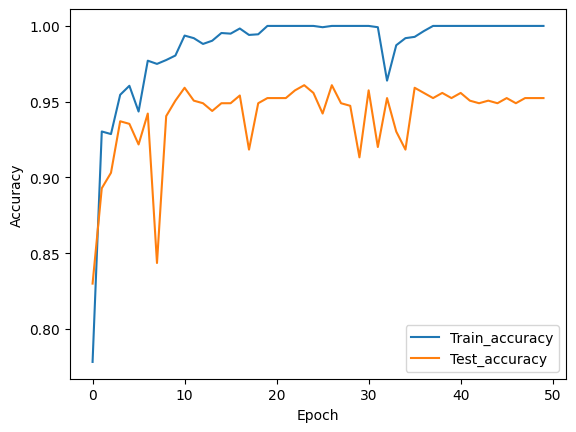


Train_accuracy 0.9706881642341614
Test_accuracy: 0.9523809552192688
Val_accuracy: 0.9687924385070801


In [171]:
# Plotte die Learning-curve - sowohl auf dem Test als auch auf dem Validierungsdatenset sind die Ergebnisse gut
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig("./output/learning_curves_new.png")
plt.show()

print()
#print('Evaluation by evaluate:')
score = model.evaluate(train_dataset, verbose=False)
print('Train_accuracy', score[1])  # score[0]=loss. score[1]=accuracy
score = model.evaluate(test_dataset, verbose=False)
print('Test_accuracy:', score[1])
score = model.evaluate(validation_dataset, verbose=False)
print('Val_accuracy:', score[1])

In [189]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# save to csv: 
hist_csv_file = "./Output/history_"+ts+".csv"
hist_df.to_csv(hist_csv_file)

### Confusion matrix
Zuletzt wird eine Konfusionsmatrix erstellt. Dies gilt der Illustration von Ergebnissen, aber auch um zu verstehen welche Art von Fehler bei Misklassifikationen vorliegt.
Wir sehen das insbesondere der "schlimmere" Fehler (True label = Brown oder Yellow rust aber predicted label Healthy) nicht allzu oft vorkommt. Wäre dies nicht der Fall könnte über eine zusätzliche Gewichtung im Modell nachgedacht werden

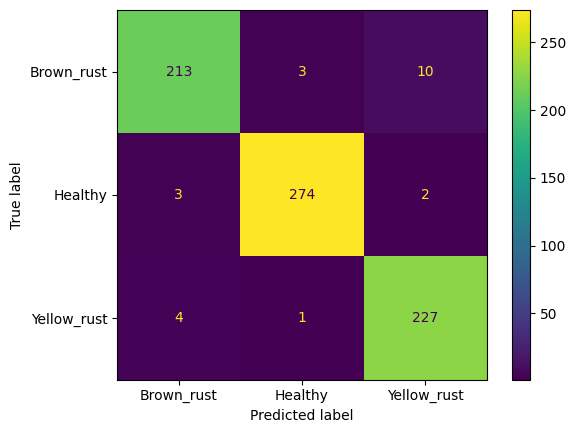

In [174]:
# Prediction und wirkliche Werte für das Validation Dataset in 2 Listen speichern und dann in einer Konfusionsmatrix plotten

#Listen initialisieren
y_pred = []
y_test = []

#für jedes Image predictions generieren und mit den wahren labels speichern - for loop ist wichtig aufgrund des "shuffle = True" arguments
for images, labels in validation_dataset:
    y_pred.extend(model.predict(images, verbose=False))
    y_test.extend(labels.numpy())

# Listen in numpy arrays convertieren
y_pred = np.array(y_pred)
y_test = np.array(y_test)

#Predictions = Klasse mit hoechster Wahrscheinlichkeit / softmax Wert
y_pred = np.argmax(y_pred, axis=1)

#Generiere Confusionsmatrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = class_names)
disp.plot()
plt.savefig("./output/confusionmatrix_"+ts+".png")
plt.show()


### Conclusion
* Nutzung des Deep Learning Keras Pakets erlaubt es ohne viel Aufwand mehr als befriedigende Ergebnisse zu erzielen
* Identifikation von kranken Mais, sowie der vorliegenden Krankheit, ist zu mehr als 95% korrekt - auf allen Datensets und erlaubt damit eine zuverlässige Identifikation
* Die Nutzung vorgebauter Modelle (z.B. VGG16, nicht in Scope) erhöht die Accuracy um maximal 1-2% und war, da "pre-built", nicht Fokus der Projektarbeit

## Appendix - Evaluation
Zusätzlich zu obenstehenden Metriken sehen wir untenstehend an einigen Beispielbildern sowohl die Vorhersagen als auch die tatsächlichen Klassen

<Figure size 2000x1500 with 0 Axes>

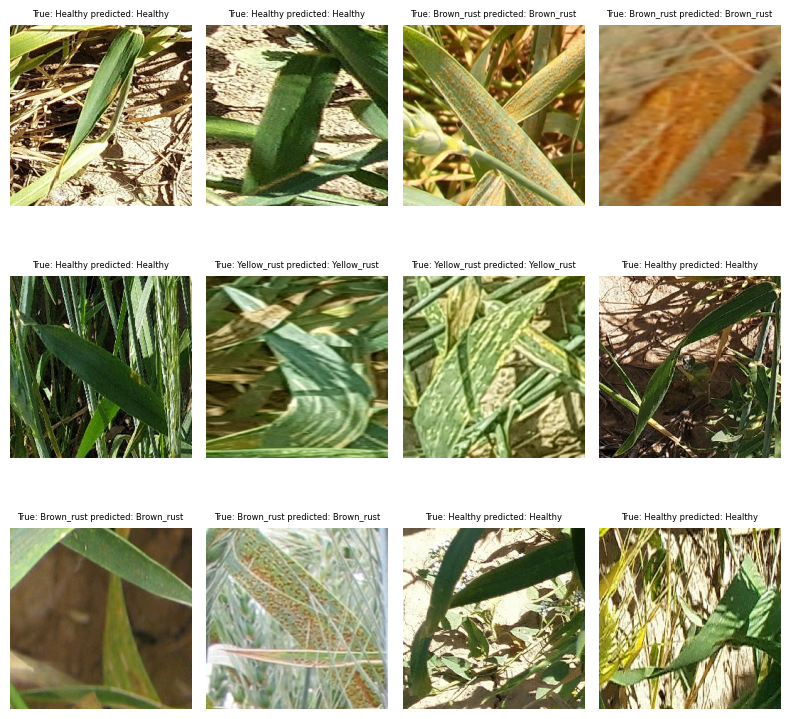

In [175]:
### Beispielplots der Klassen aus dem ersten Batch sowie den zugehörigen Vorhersagen

#Anzahl plots pro Klasse
IMAGES_TO_PLOT = 12
images = []
true_labels =  []
pred_labels = []
#Für images im ersten "Batch" (die ersten BATCHSIZE items) füge die Bilder der passenden Liste hinzu
plt.figure(figsize=(20,15))
for image , labels in validation_dataset.take(1):
    true_labels.extend(labels)
    pred = model.predict(image, verbose=False)
    pred_labels.extend(np.argmax(pred, axis=1))
    for i in range(BATCH_SIZE):
        images.append(image[i].numpy().astype("uint8"))
        pred_labels.append(np.argmax(pred, axis=1))
        
true_labels = [class_names[i.numpy()] for i in true_labels]

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = images[i]
    fig.add_subplot(rows, columns, i)
    string = "True: " + true_labels[i] + " predicted: "+ class_names[pred_labels[i]]
    plt.title(string,   fontsize = 6)
    plt.axis("off")
    plt.imshow(img)
plt.savefig("./output/AppendixFigure.png")
fig.tight_layout()
plt.show()

In [176]:
#Reload with one big dataset to avoid the batches - predict again, because of the shuffling
validation_dataset = image_dataset_from_directory(val_directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=800,
                                             image_size=IMG_SIZE,
                                             color_mode='rgb',
                                             seed=42)

Found 737 files belonging to 3 classes.


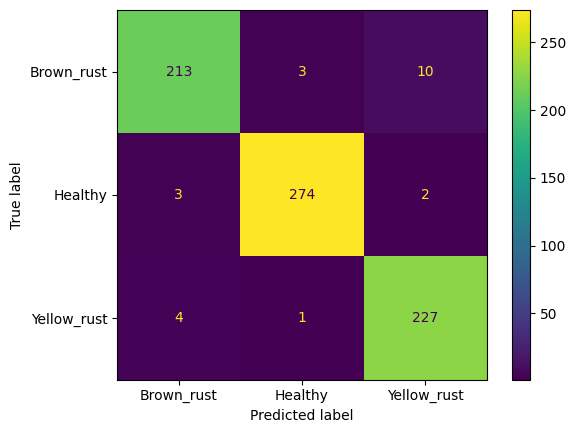

In [178]:
# Prediction und wirkliche Werte für das Validation Dataset in 2 Listen speichern und dann in einer Konfusionsmatrix plotten

#Listen initialisieren
y_pred = []
y_test = []

#für jedes Image predictions generieren und mit den wahren labels speichern - for loop ist wichtig aufgrund des "shuffle = True" arguments
for images, labels in validation_dataset:
    y_pred.extend(model.predict(images, verbose=False))
    y_test.extend(labels.numpy())

# Listen in numpy arrays convertieren
y_pred = np.array(y_pred)
y_test = np.array(y_test)

#Predictions = Klasse mit hoechster Wahrscheinlichkeit / softmax Wert
y_pred = np.argmax(y_pred, axis=1)

#Generiere Confusionsmatrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = class_names)
disp.plot()
plt.show()


In [179]:
indices = []
wrong_pred = []
#Gives the indices of the wrongly predicted samples
for i in range(len(y_test)):
  if y_test[i]!=y_pred[i]:
    indices.append(i)
    wrong_pred.append([class_names[y_test[i]],class_names[y_pred[i]]])
len(wrong_pred)  

23

In [180]:
val_ds = tuple(zip(*validation_dataset))

In [181]:
images=[]
for i in indices:
  image = np.array(val_ds[0][0][i])
  images.append(image)


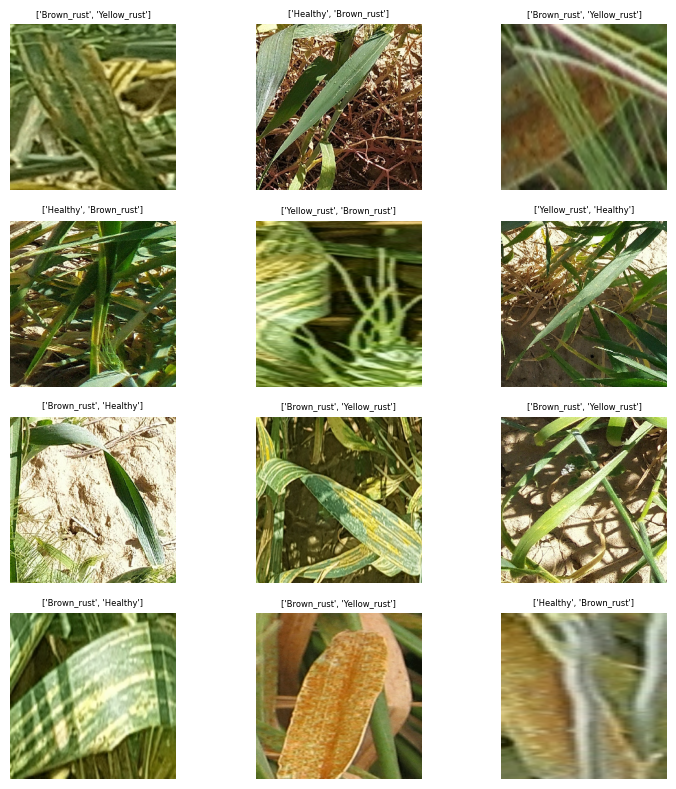

In [185]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 4
for i in range(0, columns*rows):
    img = images[i].astype("uint8")
    fig.add_subplot(rows, columns, i+1)
    string = wrong_pred[i]
    plt.title(string,   fontsize = 6)
    plt.axis("off")
    plt.imshow(img)
plt.savefig("./output/Example_incorrectly_classified_"+ts+".png")
fig.tight_layout()
plt.show()